In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
url = '../processed_data/output.csv'
df1 = pd.read_csv(url, index_col = 'year', parse_dates=True, infer_datetime_format=True)
print(df1.shape)  
df1.head()

(12793, 25)


,country,sex,age,suicides,population,sucid_in_hundredk,country-year,yearly_gdp,gdp_per_capita,generation,...,physician_price,laborforcetotal,lifeexpectancy,mobilesubscriptions,refugees,selfemployed,electricityacess,continent,country_code,mobilesubscription
year,,,,,,,,,,,,,,,,,,,,,
1985-01-01,Argentina,male,75+ years,202,363000,55.65,Argentina1985,8.841667e+10,3264,G.I. Generation,...,1.817658,1.077831e+07,50.156848,44.867006,10732.386792,2.157578,64.426681,Americas,ARG,0.0
1985-01-01,Argentina,male,55-74 years,485,1997000,24.29,Argentina1985,8.841667e+10,3264,G.I. Generation,...,1.817658,1.077831e+07,50.156848,44.867006,10732.386792,2.157578,64.426681,Americas,ARG,0.0
1985-01-01,Argentina,male,35-54 years,414,3346300,12.37,Argentina1985,8.841667e+10,3264,Silent,...,1.817658,1.077831e+07,50.156848,44.867006,10732.386792,2.157578,64.426681,Americas,ARG,0.0
1985-01-01,Argentina,female,55-74 years,210,2304000,9.11,Argentina1985,8.841667e+10,3264,G.I. Generation,...,1.817658,1.077831e+07,50.156848,44.867006,10732.386792,2.157578,64.426681,Americas,ARG,0.0
1985-01-01,Argentina,male,25-34 years,177,2234200,7.92,Argentina1985,8.841667e+10,3264,Boomers,...,1.817658,1.077831e+07,50.156848,44.867006,10732.386792,2.157578,64.426681,Americas,ARG,0.0


In [4]:
df1.columns

Index(['country', 'sex', 'age', 'suicides', 'population', 'sucid_in_hundredk',
       'country-year', 'yearly_gdp', 'gdp_per_capita', 'generation',
       'suicide%', 'internetusers', 'expenses', 'employeecompensation',
       'unemployment', 'physician_price', 'laborforcetotal', 'lifeexpectancy',
       'mobilesubscriptions', 'refugees', 'selfemployed', 'electricityacess',
       'continent', 'country_code', 'mobilesubscription'],
      dtype='object')

In [5]:
df = df1[(df1.country == 'Russian Federation')]
columns = ['sucid_in_hundredk','gdp_per_capita','lifeexpectancy','expenses']
df = pd.DataFrame(df1, columns=columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12793 entries, 1985-01-01 to 2015-01-01
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sucid_in_hundredk  12793 non-null  float64
 1   gdp_per_capita     12793 non-null  int64  
 2   lifeexpectancy     12793 non-null  float64
 3   expenses           12793 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 499.7 KB


In [6]:
# adding all deaths together and group by year
df = df.groupby(['year'])['sucid_in_hundredk','gdp_per_capita','lifeexpectancy','expenses'].transform('sum')
df['year'] = list(df.index)
df = df.drop_duplicates()
df = df.drop(labels='year', axis=1)
df.tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,sucid_in_hundredk,gdp_per_capita,lifeexpectancy,expenses
year,,,,
2007-01-01,4925.97,13706178,34462.996731,13100.439338
2008-01-01,5027.80,14964040,34731.549366,13781.643021
2009-01-01,4885.89,13120714,34260.406342,14549.026492
2010-01-01,5164.36,14033499,34940.614878,14947.996213
2011-01-01,5133.46,15646338,35379.578268,14774.776695
2012-01-01,5220.04,15136138,35521.615073,14858.847464
2013-01-01,4474.26,15153178,33962.116756,14265.493500
2014-01-01,4851.48,14233710,21818.229001,8746.914091
2015-01-01,4219.66,11055237,19460.857132,7801.845212


In [7]:
df.isnull().sum()
df.isna().sum()

sucid_in_hundredk    0
gdp_per_capita       0
lifeexpectancy       0
expenses             0
dtype: int64

In [8]:
# Replace the NaNs in column S2 & S3 by the mean of values
# in column S2 & S3 respectively
df[['lifeexpectancy','expenses']] = df[['lifeexpectancy','expenses']].fillna(value=df[['lifeexpectancy','expenses']].mean())

In [9]:
df['lifeexpectancy'] = df['lifeexpectancy'].replace(0, 
df['lifeexpectancy'].median())

df['expenses'] = df['expenses'].replace(0, 
df['expenses'].median())

In [10]:
df.isnull().sum()
df.isna().sum()

sucid_in_hundredk    0
gdp_per_capita       0
lifeexpectancy       0
expenses             0
dtype: int64

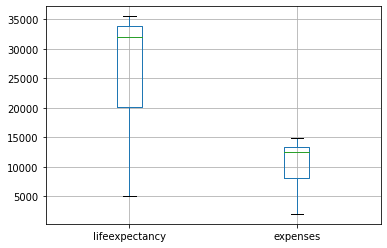

In [11]:
boxplot = df.boxplot(column=['lifeexpectancy','expenses']) 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


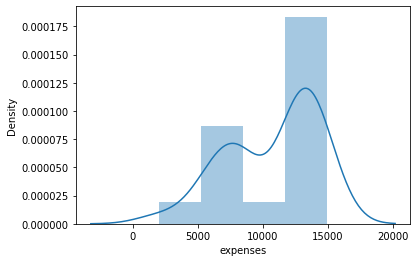

In [12]:
import seaborn as sns, numpy as np
ax = sns.distplot(df['expenses'])

In [13]:
df.head()

,sucid_in_hundredk,gdp_per_capita,lifeexpectancy,expenses
year,,,,
1985-01-01,3445.18,1767244,13040.780553,5228.040606
1986-01-01,3930.40,2546796,13843.290125,5549.766182
1987-01-01,5035.65,3611844,16250.818842,6514.942909
1988-01-01,4700.49,4022209,15598.779815,6253.540879
1989-01-01,5208.18,4218240,16852.701022,6756.237091


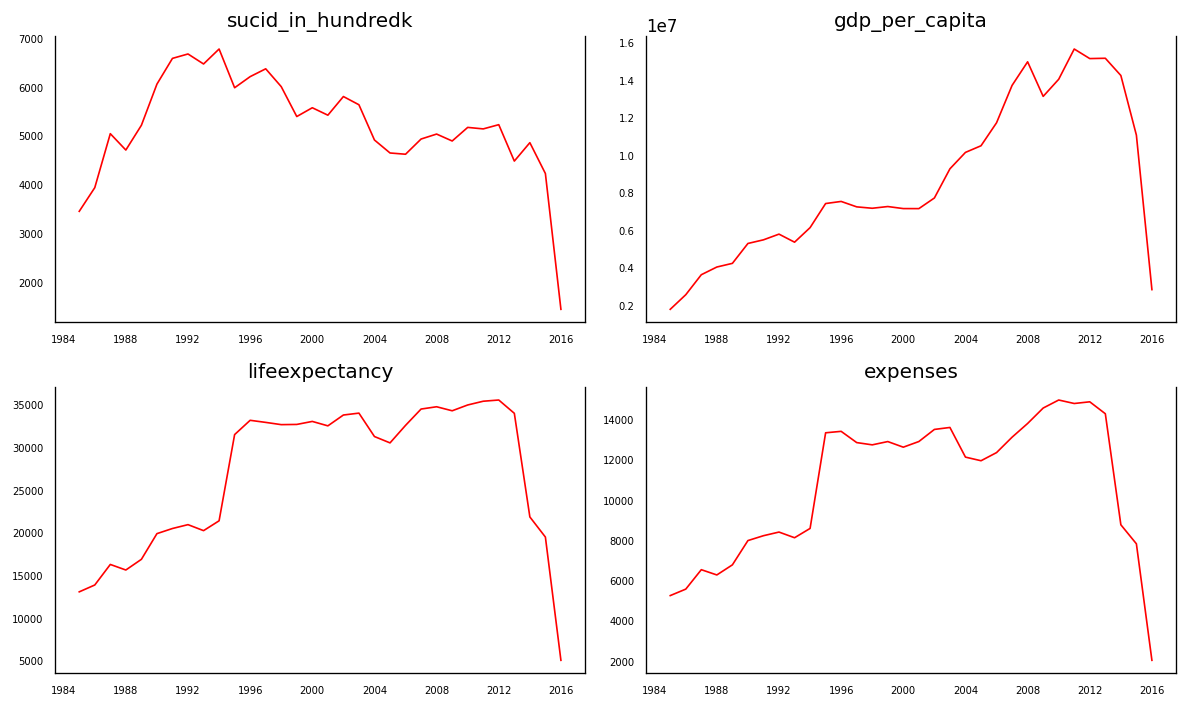

In [14]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Testing Causation using Granger’s Causality Test

In [15]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=9
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,sucid_in_hundredk_x,gdp_per_capita_x,lifeexpectancy_x,expenses_x
sucid_in_hundredk_y,1.0000,0.0,0.0,0.0
gdp_per_capita_y,0.0159,1.0,0.0,0.0
lifeexpectancy_y,0.0000,0.0,1.0,0.0
expenses_y,0.0000,0.0,0.0,1.0


If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

### Cointegration Test

In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
sucid_in_hundredk ::  nan       > 40.1749   =>   False
gdp_per_capita ::  702.82    > 24.2761   =>   True
lifeexpectancy ::  48.5      > 12.3212   =>   True
expenses ::  2.68      > 4.1296    =>   False


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:674: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:676: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1-a[i])


In [17]:
nobs = 5
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(27, 4)
(5, 4)


Dickey-Fuller Test

In [18]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [19]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "sucid_in_hundredk" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6702
 No. Lags Chosen       = 0
 Critical value 1%     = -3.711
 Critical value 5%     = -2.981
 Critical value 10%    = -2.63
 => P-Value = 0.0793. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "gdp_per_capita" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.7609
 No. Lags Chosen       = 2
 Critical value 1%     = -3.738
 Critical value 5%     = -2.992
 Critical value 10%    = -2.636
 => P-Value = 0.991. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "lifeexpectancy" 
    -----------------------------------------------
 Nul

In [20]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [21]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "sucid_in_hundredk" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.3782
 No. Lags Chosen       = 0
 Critical value 1%     = -3.724
 Critical value 5%     = -2.986
 Critical value 10%    = -2.633
 => P-Value = 0.0003. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "gdp_per_capita" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7601
 No. Lags Chosen       = 1
 Critical value 1%     = -3.738
 Critical value 5%     = -2.992
 Critical value 10%    = -2.636
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "lifeexpectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

In [22]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [23]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "sucid_in_hundredk" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0687
 No. Lags Chosen       = 4
 Critical value 1%     = -3.809
 Critical value 5%     = -3.022
 Critical value 10%    = -2.651
 => P-Value = 0.029. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "gdp_per_capita" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.6351
 No. Lags Chosen       = 2
 Critical value 1%     = -3.77
 Critical value 5%     = -3.005
 Critical value 10%    = -2.643
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "lifeexpectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

In [24]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [25]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "sucid_in_hundredk" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2203
 No. Lags Chosen       = 5
 Critical value 1%     = -3.859
 Critical value 5%     = -3.042
 Critical value 10%    = -2.661
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "gdp_per_capita" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5746
 No. Lags Chosen       = 2
 Critical value 1%     = -3.788
 Critical value 5%     = -3.013
 Critical value 10%    = -2.646
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "lifeexpectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

In [26]:
model = VAR(df_differenced)
for i in [1,2,3]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  71.38417988563852
BIC :  72.37156616035952
FPE :  1.0327680008467646e+31
HQIC:  71.63250476615116 

Lag Order = 2
AIC :  70.98346806210047
BIC :  72.768810258505
FPE :  8.242794193943304e+30
HQIC:  71.40404099957529 

Lag Order = 3
AIC :  67.47832408989454
BIC :  70.06476060235254
FPE :  4.6583037160167115e+29
HQIC:  68.0396470237916 



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


In [27]:
model.select_order(3)
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     10:24:29
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    70.0648
Nobs:                     21.0000    HQIC:                   68.0396
Log likelihood:          -775.713    FPE:                4.65830e+29
AIC:                      67.4783    Det(Omega_mle):     6.77937e+28
--------------------------------------------------------------------
Results for equation sucid_in_hundredk
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                      -10.967003        61.225144           -0.179           0.858
L1.sucid_in_hundredk        -1.096626         0.126225           -8.688           0.000
L1.gdp_per_capita   

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [28]:
def adjust(val, length= 6): return str(val).ljust(length)

In [29]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

sucid_in_hundredk : 0.49
gdp_per_capita : 1.5
lifeexpectancy : 2.24
expenses : 2.23


### The serial correlation seems quite alright. Let’s proceed with the forecast.

In [30]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[-3.41900000e+01, -2.36653700e+06,  9.03606536e+02,
         1.70859275e+02],
       [ 6.64120000e+02,  5.85729900e+06,  1.89104722e+03,
        -4.54593536e+02],
       [-7.29750000e+02, -2.05605700e+06, -1.39259671e+03,
        -2.03775490e+02]])

### Forecast VAR model using statsmodels

In [31]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,sucid_in_hundredk_2d,gdp_per_capita_2d,lifeexpectancy_2d,expenses_2d
year,,,,
2012-01-01,354.983546,-3.331729e+06,-7221.815277,-889.792760
2013-01-01,-716.785772,-1.504501e+06,11694.353892,3451.806013
2014-01-01,2353.018203,8.790193e+06,-4547.189046,-4218.988398
2015-01-01,-3092.645004,-8.918612e+05,536.093541,2475.261742
2016-01-01,1221.574387,-1.244400e+07,-11448.295805,-2239.090448


In [32]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

### Invert the transformation to get the real forecast

In [33]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['sucid_in_hundredk_2d', 'gdp_per_capita_2d', 'lifeexpectancy_2d','expenses_2d']]

,sucid_in_hundredk_2d,gdp_per_capita_2d,lifeexpectancy_2d,expenses_2d
year,,,,
2012-01-01,354.983546,-3.331729e+06,-7221.815277,-889.792760
2013-01-01,-716.785772,-1.504501e+06,11694.353892,3451.806013
2014-01-01,2353.018203,8.790193e+06,-4547.189046,-4218.988398
2015-01-01,-3092.645004,-8.918612e+05,536.093541,2475.261742
2016-01-01,1221.574387,-1.244400e+07,-11448.295805,-2239.090448


### Plot of Forecast vs Actuals

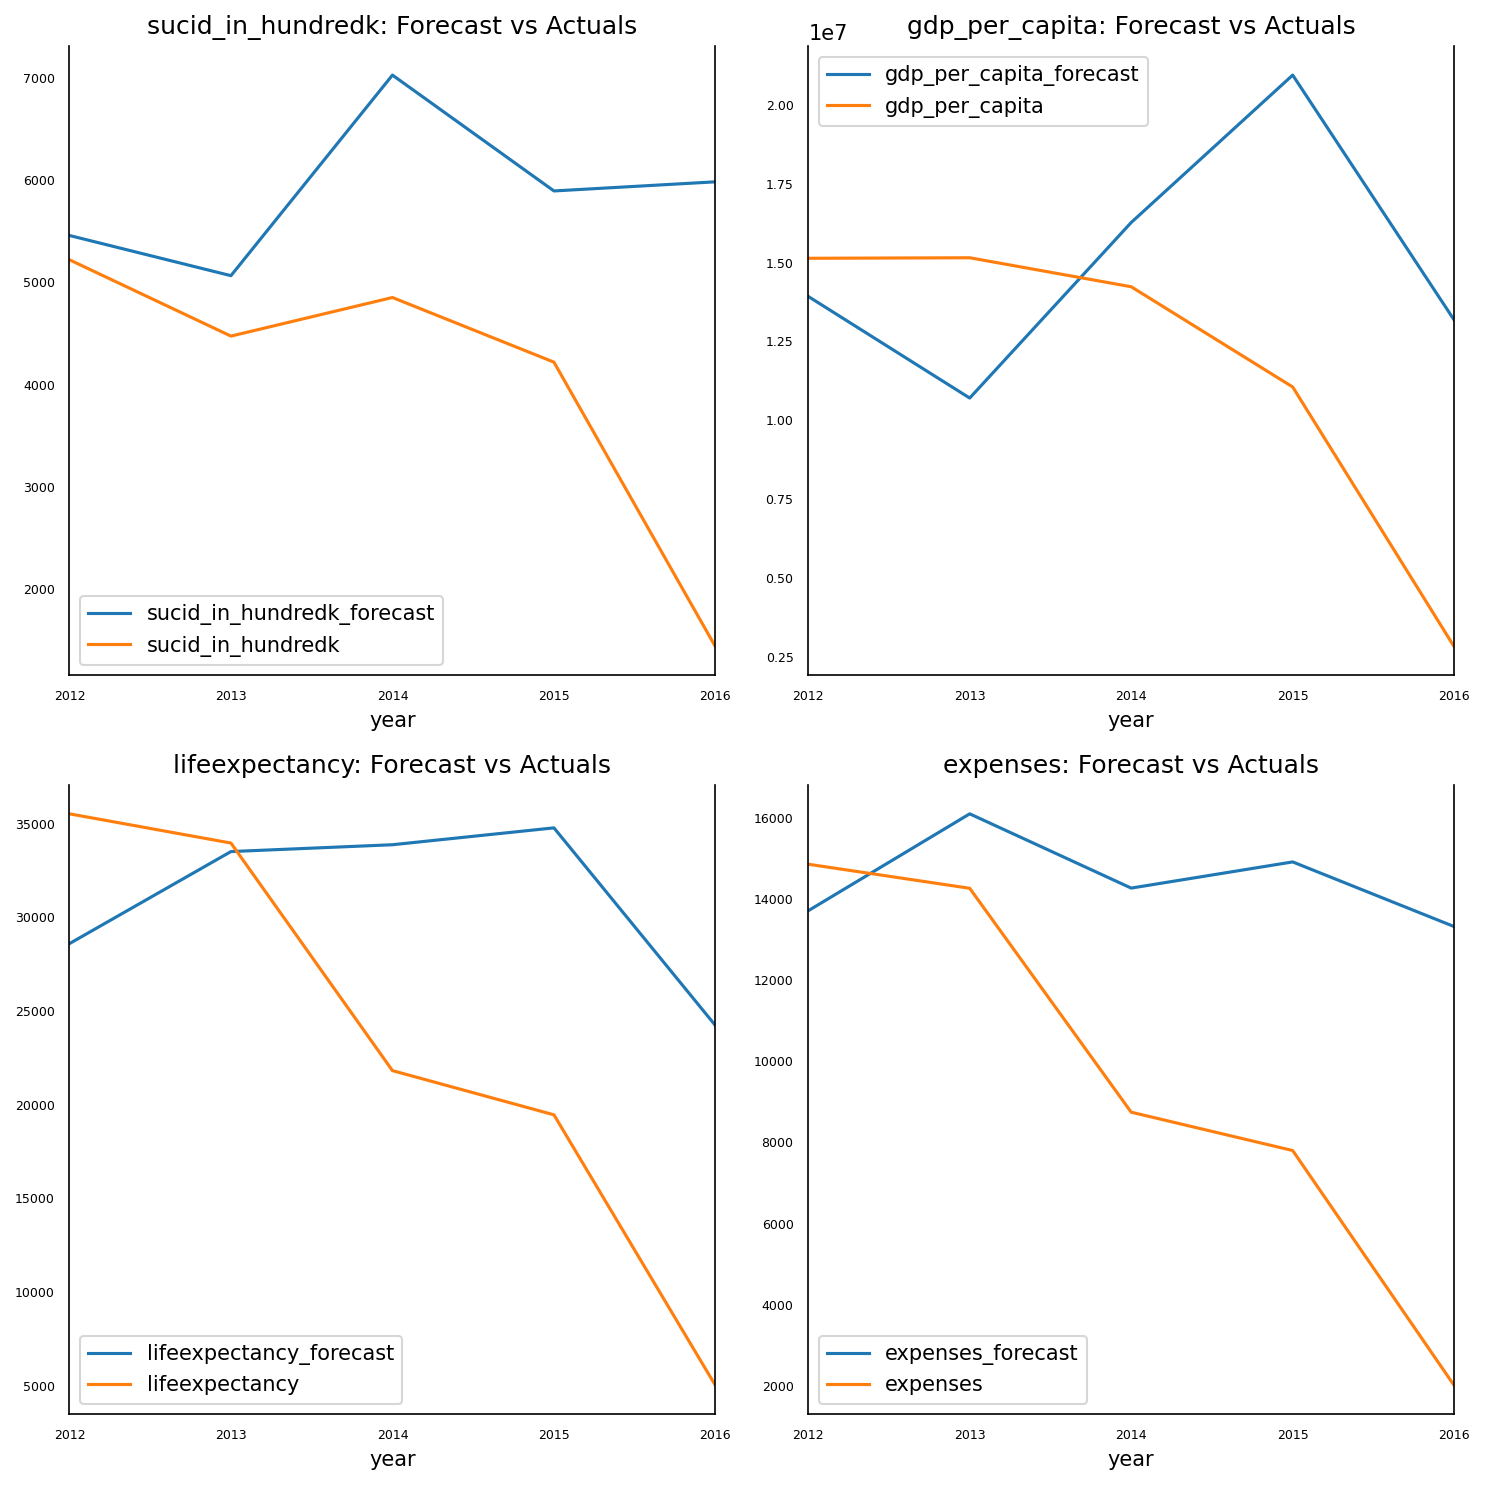

In [34]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### Evaluate the Forecasts

In [35]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: gdp_per_capita')
accuracy_prod = forecast_accuracy(df_results['gdp_per_capita_forecast'].values, df_test['gdp_per_capita'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: lifeexpectancy')
accuracy_prod = forecast_accuracy(df_results['lifeexpectancy_forecast'].values, df_test['lifeexpectancy'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: sucid_in_hundredk')
accuracy_prod = forecast_accuracy(df_results['sucid_in_hundredk_forecast'].values, df_test['sucid_in_hundredk'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: expenses')
accuracy_prod = forecast_accuracy(df_results['expenses_forecast'].values, df_test['expenses'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: gdp_per_capita
mape   :  1.0175
me     :  3325799.3485
mae    :  5588923.5412
mpe    :  0.8682
rmse   :  6790282.297
corr   :  -0.0363
minmax :  0.3514

Forecast Accuracy of: lifeexpectancy
mape   :  1.0755
me     :  7839.3999
mae    :  10790.9108
mpe    :  0.9922
rmse   :  12624.7907
corr   :  0.4611
minmax :  0.3595

Forecast Accuracy of: sucid_in_hundredk
mape   :  0.8362
me     :  1843.7208
mae    :  1843.7208
mpe    :  0.8362
rmse   :  2390.5869
corr   :  -0.0422
minmax :  0.3026

Forecast Accuracy of: expenses
mape   :  1.4748
me     :  4927.1277
mae    :  5385.961
mpe    :  1.4439
rmse   :  6537.9665
corr   :  0.5076
minmax :  0.3808


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':
